In [ ]:
#######################
# 提取样本 #
#######################
# 首先根据风速，均速大于20的点全部认为安全概率为0.这样的FN小于0.4%，且几乎分布在危险风速边缘，故忽略其影响

In [8]:
###########################################
# 探索绝对正确的点和绝对错误的点 #
###########################################
import pickle
from tqdm import tqdm
x_max = 548
y_max = 421
file_weather = open('weather_train_average.pkl', 'rb')
weather_input = pickle.load(file_weather)
file_weather2 = open('weather_train_label_1_5.pkl', 'rb')
weather_output = pickle.load(file_weather2)
negative = set()
sample ={
    '1':[],
    '2':[],
    '3':[],
    '4':[],
    '5':[]
}

for d in range(1,6):
    for h in tqdm(range(3,21)):
        for x in range(x_max):
            for y in range(y_max):
                # FP
                if weather_output[str(d)][str(h)][0,x,y]>=15 or weather_output[str(d)][str(h)][1,x,y]>=4:
                    negative.add((d,h,x,y))
                else:
                    # 根据风速和雨水情况分层抽样
                    tianqi = weather_input[str(d)][str(h)][0,x,y]
                    rainfall = weather_input[str(d)][str(h)][1,x,y]
                    if tianqi>=15 or rainfall>=4:
                        sample['1'].append((d,h,x,y))
                    elif tianqi>=13:
                        sample['2'].append((d,h,x,y))
                    elif tianqi>=11:
                        sample['3'].append((d,h,x,y))
                    elif tianqi>=9:
                        sample['4'].append((d,h,x,y))
                    else:
                        sample['5'].append((d,h,x,y))


100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


In [9]:
# 分层抽样
import random
ratio = [0.98,0.85,0.75,0.7]
for i in range(1,5):
    sample[str(i)] = random.sample(sample[str(i)],int(len(sample[str(i)])*ratio[i-1]))
remain = len(negative)-sum([len(sample[str(i)]) for i in range(1,5)])
print(remain)
sample['5'] = random.sample(sample['5'],remain)
print(remain)

1900547
1900547


In [10]:
for i in range(1,6):
    print(len(sample[str(i)]))

524734
1986563
2170292
1559450
1900547


In [11]:
positive = set()
for i in range(1,6):
    positive = positive|set(sample[str(i)])
sample = positive|negative
##################################################### 样本集合构建完毕
import pickle
f1 = open('sample.pkl', 'wb')
pickle.dump(sample,f1)
f1.close()

In [5]:
# 获取采样目录
import pickle
from tqdm import tqdm
import numpy as np
x_max = 548
y_max = 421
sample_set = pickle.load(open('sample.pkl','rb'))
i = 0
sample_index = []
for d in range(1,6):
    for h in tqdm(range(3,21)):
        for x in range(x_max):
            for y in range(y_max):
                if (d,h,x,y) in sample_set:
                    sample_index.append(i)
                else:
                    pass
                i+=1
np.save('sample_index.npy',np.array(sample_index))

100%|██████████| 18/18 [00:02<00:00,  7.59it/s]


In [7]:
len(sample_index)

16283172

In [ ]:
#######################
# 风团分割 #
#######################
# 没错我是天气预报员

In [1]:
import pickle
import numpy as np
import sys
from tqdm import tqdm
output_weather = open('weather_output.pkl', 'rb')
output_weather = pickle.load(output_weather)
sys.setrecursionlimit(1500)


In [2]:
def find_wind_eye(data,x,y,d):
    #print(x,y)
    x_max = 548
    y_max = 421
    width = int((d-1)/2)
    x_up = max(0,x-width)
    x_down = min(x_max,x+width+1)
    y_left = max(0,y-width)
    y_right = min(y_max,y+width+1)
    block = data[x_up:x_down,y_left:y_right]
    index = np.argmax(block)
    #print(index)
    #print(y_right-y_left)
    x_s = index//(y_right-y_left)+x_up
    y_s = index%(y_right-y_left)+y_left

    #print(x_s,y_s,np.max(block),block)
    if x_s == x and y_s == y:
        return (x_s,y_s)
    else:

        return find_wind_eye(data,x_s,y_s,d)

In [3]:
# 风速最大的地方成为凤眼
# 参数
# 风团最小直径
d = 9
# 团队形成条件，风速大于10，或者最大差大于3
low = 10
delta = 5
# 风团集合
x_max = 548
y_max = 421
wind = {}
data = output_weather['5']['5']
for x in tqdm(range(x_max)):
    for y in range(y_max):
        if data[x,y]<8:
            pass
        else:
            eye = find_wind_eye(data,x,y,d)
            if eye in wind.keys():
                wind[eye].append((x,y))
            else:
                wind[eye] = []
                wind[eye].append((x,y))

100%|██████████| 548/548 [00:03<00:00, 159.97it/s]


In [14]:
len(wind)

309

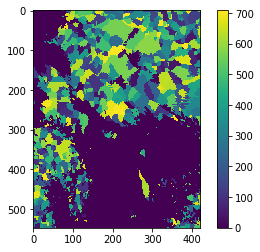

In [4]:
import copy
import matplotlib.pyplot as plt
fig = plt.figure()
testdata = copy.deepcopy(data)
testdata[testdata<8] = 0
n = len(wind)
i = 1
for key,values in wind.items():
    for sth in values:
        testdata[sth[0],sth[1]] = i
    i += 1
im = plt.imshow(testdata)
plt.colorbar(im, shrink=1) 
plt.show()


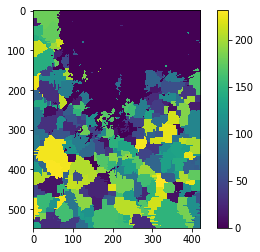

In [105]:
import copy
import matplotlib.pyplot as plt
fig = plt.figure()
testdata = copy.deepcopy(data)
testdata[testdata<8] = 0
n = len(wind)
i = 1
for key,values in wind.items():
    for sth in values:
        testdata[sth[0],sth[1]] = i
    i += 1
im = plt.imshow(testdata)
plt.colorbar(im, shrink=1) 
plt.show()


In [ ]:
# 开始建立所有样本的周边特征 ######################
# important
windeye= []
# 风眼离我的距离，风眼相对我的速度增量

In [ ]:
# 设计卷积寻找特征
# 1 八个方向的风速波浪
# 2 中间高周围小，中间小周围高，中间小两边大，中间大两边小

In [ ]:
# 设置边缘信息特征
# 最近边缘信息，周围边缘点个数

In [ ]:
# 风速变化特征
# 周围风速情况，历史风速情况

In [ ]:
# 风速移动情况
# 卷积